## GOAL

Analyze financial transaction data to predit if a particular transaction data is fraudulent.

In [118]:
import boto3

import numpy as np 
import pandas as pd
import os
from sklearn.utils import shuffle

region = boto3.Session().region_name    

bucket = 'anomaly-detection-team-vypin'                     
prefix = 'sagemaker/talasila'

---
## DOWNLOAD

In [119]:
s3 = boto3.resource('s3')
data_bucket = 'anomaly-detection-team-vypin'
data_key = 'PS_20174392719_1491204439457_log.csv'
s3.Bucket(data_bucket).download_file(data_key, 'input_data.csv')

Read data into a pandas dataframe

In [120]:
df = pd.read_csv('./input_data.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


---
## Analysis

bin transaction amounts into 50K range

In [121]:
# bin amounts into 50K range
bins = range(0, 1000000, 50000)
labels = range(0, 950000, 50000)
df['binned'] = pd.cut(df['amount'], bins=bins, labels=labels)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,binned
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0


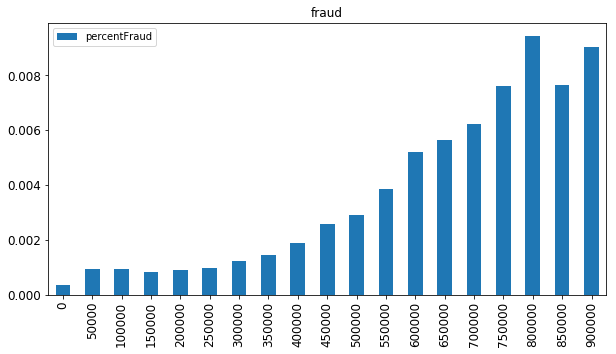

In [122]:
# analysis: set what percentage of tx in each bin is fraudulent

#df[['amount']].plot(kind='hist',bins=bins,rwidth=0.8)
adf1 = df['binned'].value_counts().to_frame('totalTx')
adf1['bin'] = adf1.index

fraud = df.loc[df['isFraud'] == 0].groupby(['binned']).size().to_frame('nonfraud')
adf1 = adf1.join(fraud, lsuffix='', rsuffix='', sort=False)
adf1['percentFraud'] = (adf1['totalTx'] - adf1['nonfraud'])/adf1['totalTx']

adf1[['bin','percentFraud']].plot(kind='bar', title ="fraud", figsize=(10, 5), legend=True, fontsize=12)



---
## MUNGING

In [123]:
df = pd.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=['type'])
df = shuffle(df)
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,binned,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2823775,226,48228.06,C1964435730,0.00,0.00,M213324882,0.00,0.00,0,0,0,0,0,0,1,0
1608649,156,440260.79,C1276427568,66620.18,506880.96,C355900651,1997242.17,1556981.38,0,0,400000,1,0,0,0,0
1157112,131,29246.23,C899934233,0.00,0.00,M298249173,0.00,0.00,0,0,0,0,0,0,1,0
4446368,323,52578.36,C2075189766,237242.44,184664.08,M1162028936,0.00,0.00,0,0,50000,0,0,0,1,0
3773646,280,16283.30,C706293451,0.00,0.00,M774614297,0.00,0.00,0,0,0,0,0,0,1,0


Split data into the training, test and validation sets

In [125]:
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9*len(model_data))])  

train_data.to_csv('train_actual.csv', index=True, header=True)
validation_data.to_csv('validation_actual.csv', index=True, header=True)
test_data.to_csv('test_actual.csv', index=True, header=True)

train_data_munged = train_data.drop(['nameOrig', 'nameDest', 'binned', 'isFraud', 'isFlaggedFraud'], axis=1)
validation_data_munged = validation_data.drop(['nameOrig', 'nameDest', 'binned', 'isFraud', 'isFlaggedFraud'], axis=1)
test_data_munged = test_data.drop(['nameOrig', 'nameDest', 'binned', 'isFraud', 'isFlaggedFraud'], axis=1)

train_data_munged.to_csv('train_munged.csv', index=False, header=False)
validation_data_munged.to_csv('validation_munged.csv', index=False, header=False)
test_data_munged.to_csv('test_munged.csv', index=False, header=False)

Copy to S3

In [126]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train_actual.csv')).upload_file('train_actual.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation_actual.csv')).upload_file('validation_actual.csv')

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train_munged.csv')).upload_file('train_munged.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation_munged.csv')).upload_file('validation_munged.csv')

---
## Training

In [128]:
import sagemaker
import boto3
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker import RandomCutForest
import pandas as pd

smclient = boto3.Session().client('sagemaker')
role = sagemaker.get_execution_role()
session = sagemaker.Session()
bucket = 'anomaly-detection-team-vypin'                     
prefix = 'sagemaker/talasila'

# specify general training job information
rcf = RandomCutForest(role=role,
                      train_instance_count=1,
                      train_instance_type='ml.m5.12xlarge',
                      data_location='s3://{}/{}/train/train_munged.csv'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

train_data = pd.read_csv('s3://{}/{}/train/train_munged.csv'.format(bucket, prefix))

# run the training job on input data stored in S3
rcf.fit(rcf.record_set(train_data.as_matrix()))


INFO:sagemaker:Creating training-job with name: randomcutforest-2019-03-07-17-54-29-240


2019-03-07 17:54:29 Starting - Starting the training job...
2019-03-07 17:54:30 Starting - Launching requested ML instances......
2019-03-07 17:55:41 Starting - Preparing the instances for training...
2019-03-07 17:56:26 Downloading - Downloading input data
2019-03-07 17:56:26 Training - Downloading the training image......
2019-03-07 17:57:26 Uploading - Uploading generated training model
Docker entrypoint called with argument(s): train
[03/07/2019 17:57:18 INFO 140466286872384] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[03/07/2019 17:57:18 INFO 140466286872384] Reading provided configur

[2019-03-07 17:57:24.779] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 1, "duration": 5400, "num_examples": 4454, "num_bytes": 498829296}
[03/07/2019 17:57:24 INFO 140466286872384] Sampling training data completed.
#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 5410.279035568237, "sum": 5410.279035568237, "min": 5410.279035568237}}, "EndTime": 1551981444.788623, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "RandomCutForest"}, "StartTime": 1551981439.367329}

[03/07/2019 17:57:24 INFO 140466286872384] Early stop condition met. Stopping training.
[03/07/2019 17:57:24 INFO 140466286872384] #progress_metric: host=algo-1, completed 100 % epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 4454, "sum": 4454.0, "min": 4454}, "Number of Batches Since Last Reset": {"count": 1, "max": 4454, "sum": 4454.0, "min": 4454}, "Number of Reco

---
## Inference

Run inference for a small sample to test.

In [129]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2019-03-07-18-00-29-472
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-03-07-17-54-29-240


-------------------------------------------------------------------------!

In [130]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [131]:
train_data_munged_numpy = train_data_munged.as_matrix()
print(train_data_munged_numpy[:6])
results = rcf_inference.predict(train_data_munged_numpy[:6])
print(results)

[[1.50000000e+01 1.11715390e+05 6.00650000e+04 0.00000000e+00
  7.32142803e+06 7.43314342e+06 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.74000000e+02 1.24571810e+05 0.00000000e+00 0.00000000e+00
  4.21130120e+05 5.45701920e+05 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.38000000e+02 1.19280700e+04 1.04490000e+04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [1.83000000e+02 1.95802830e+05 9.97482838e+06 1.01706312e+07
  4.39853790e+05 2.44050960e+05 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.01000000e+02 8.83495000e+03 3.74290000e+05 3.65455050e+05
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [3.79000000e+02 8.52592000e+03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00

---
## Compute anomaly scores

Use batch transform to compute anomaly scores across the data set

In [132]:
import boto3
import sagemaker
import json

validation_munged_data_file = 's3://{}/{}/validation/validation_munged.csv'.format(bucket, prefix)
output_location = 's3://{}/{}/output/batch_transform'.format(bucket, prefix)

# Initialize the transformer object
transformer = rcf.transformer(
    instance_type='ml.c4.xlarge',
    instance_count=1,
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=output_location
    )
# Start a transform job
transformer.transform(validation_munged_data_file, content_type='text/csv', split_type='Line')
# Then wait until the transform job has completed
transformer.wait()

INFO:sagemaker:Creating model with name: randomcutforest-2019-03-07-17-54-29-240
INFO:sagemaker:Creating transform job with name: randomcutforest-2019-03-07-18-08-07-960


......................................................!


In [133]:
# Download validation results 
s3.Bucket(bucket).download_file(prefix + '/output/batch_transform/validation_munged.csv.out', 'validation_munged_out.csv')

In [134]:
with open('validation_munged_out.csv') as f:
    results = f.readlines()   
print(results[0])

{"score":0.513516354}



In [135]:
scores = [json.loads(datum)['score'] for datum in results]

#add scores to validation data frame and print first few values
#m = np.asarray(scores)
validation_data['score'] = scores
validation_data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,binned,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,score
2445937,203,124388.46,C895641742,3059.0,0.00,C1299188954,1190414.88,1611628.29,0,0,100000,0,1,0,0,0,0.513516
301450,15,110572.14,C183334974,1522.0,0.00,C2040474808,0.00,110572.14,0,0,100000,0,1,0,0,0,0.410464
1989547,179,169392.44,C1062740569,0.0,0.00,C1662206385,209127.80,378520.23,0,0,150000,0,1,0,0,0,0.438368
1909643,166,14315.23,C1971735805,130595.0,116279.77,M1325884062,0.00,0.00,0,0,0,0,0,0,1,0,0.412861
1786531,162,434957.09,C1058656014,398.0,0.00,C553456018,0.00,434957.09,0,0,400000,0,0,0,0,1,0.508114


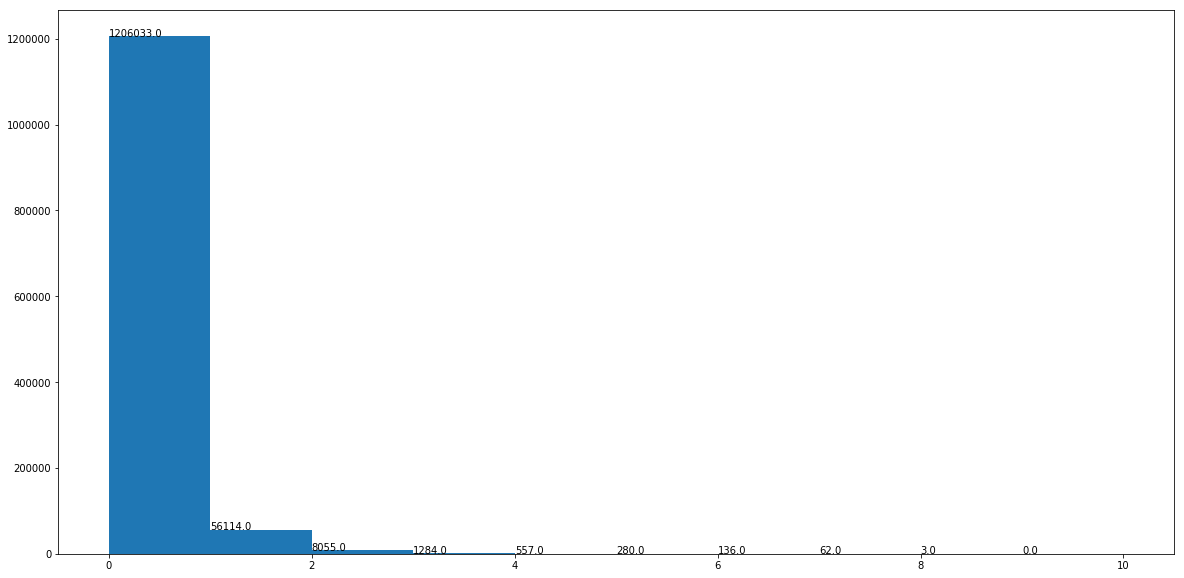

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
scores_bins = [0,1,2,3,4,5,6,7,8,9,10]
arr = plt.hist(scores, scores_bins)
for i in scores_bins:
    if i < len(scores_bins) - 1:
        plt.text(arr[1][i],arr[0][i],str(arr[0][i]))





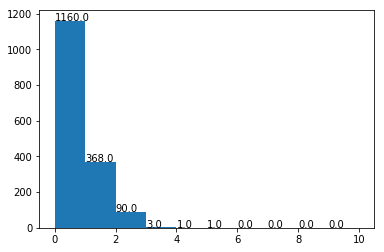

In [144]:
fraud_df = validation_data.loc[validation_data['isFraud'] == 1]

arr = plt.hist(fraud_df['score'], scores_bins)

for i in scores_bins:
    if i < len(scores_bins) - 1:
        plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
